In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Combining CSV's into single dataframe(Label1)

## English language

In [1]:
import pandas as pd
import re
from collections import Counter
import csv
from datasets import Dataset

# ------------------------------
# 1. Define Helper Functions
# ------------------------------

def read_csv_auto_sep(filepath):
    """
    Read a CSV file by attempting to auto-detect the delimiter.
    Falls back to comma if detection fails.
    """
    with open(filepath, 'r', encoding='utf-8') as f:
        sample = f.read(2048)
        try:
            dialect = csv.Sniffer().sniff(sample)
            delimiter = dialect.delimiter
        except csv.Error:
            print(f"Could not detect delimiter for {filepath}. Falling back to comma.")
            delimiter = ','
    # If only one column is detected, force comma as delimiter.
    df = pd.read_csv(filepath, sep=delimiter, encoding='utf-8', engine='python', on_bad_lines='skip')
    if len(df.columns) == 1:
        print(f"Retrying with comma separator for {filepath}...")
        df = pd.read_csv(filepath, sep=',', encoding='utf-8', engine='python', on_bad_lines='skip')
    return df

def majority_vote(row, annotator_cols):
    """
    Compute majority vote from multiple annotator columns.
    If tie or no valid votes, returns 0.
    """
    votes = [row[col] for col in annotator_cols if pd.notnull(row[col])]
    if not votes:
        return 0  # Default if no votes available
    vote_counts = Counter(votes)
    most_common = vote_counts.most_common()
    if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
        return 0  # Tie case
    return most_common[0][0]

# ------------------------------
# 2. Read English CSV
# ------------------------------

# For English, use the English CSV file (adjust path as needed)
file_en = "/home/shubham24165/NLP-Project/task_2/uli-data/training/train_en_l1.csv"
df_en = read_csv_auto_sep(file_en)
print("Columns found in English file:", df_en.columns.tolist())

# For English, we expect these annotator columns:
en_annotator_cols = ["en_a1", "en_a2", "en_a3", "en_a4", "en_a5", "en_a6"]

# Add language tag
df_en["language"] = "en"

# Apply majority vote to create final_label
df_en["final_label"] = df_en.apply(lambda row: majority_vote(row, en_annotator_cols), axis=1)

# Keep only the needed columns
df_en = df_en[["text", "final_label", "language"]]
print("English DataFrame preview:")
print(df_en.head())

# ------------------------------
# 3. Preprocessing Functions (English Only)
# ------------------------------

def preprocess_english_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'#\w+', '', text)                  # Remove hashtags
    text = re.sub(r'<handle replaced>', '', text)       # Remove handle placeholders
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    # Remove emojis and other non-alphanumeric characters (keep basic punctuation)
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"
                               u"\U0001F300-\U0001F5FF"
                               u"\U0001F680-\U0001F6FF"
                               u"\U0001F700-\U0001F77F"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    text = re.sub(r'[^\w\s]', '', text)                 # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()             # Remove extra whitespace
    return text

# Apply English preprocessing
df_en['clean_text'] = df_en['text'].apply(preprocess_english_text)

print("\nPreview with cleaned text:")
print(df_en[['text', 'clean_text', 'final_label', 'language']].head())

# ------------------------------
# 4. Convert to HuggingFace Dataset
# ------------------------------

# Here we keep only the cleaned text, final label, and language.
# # Rename 'clean_text' to 'text' for consistency.
# df_en = df_en[['clean_text', 'final_label', 'language']].rename(columns={'clean_text': 'text'})

# # Convert to a HuggingFace Dataset
# hf_dataset_en = Dataset.from_pandas(df_en)

# print("\nHuggingFace Dataset Preview:")
# print(hf_dataset_en[0])

Retrying with comma separator for /home/shubham24165/NLP-Project/task_2/uli-data/training/train_en_l1.csv...
Columns found in English file: ['text', 'key', 'en_a1', 'en_a2', 'en_a3', 'en_a4', 'en_a5', 'en_a6']
English DataFrame preview:
                                                text final_label language
0      This is our history . For Shia and Sunni ,...         0.0       en
1     If this is "grilling" then wht wud u call t...         1.0       en
2    look at <handle replaced>madam. Locals attac...         0.0       en
3    our beloved yogi ji has given money home and...         1.0       en
4  "I gonna kill that bitch"  Bitvj imma kill you...         1.0       en

Preview with cleaned text:
                                                text  \
0      This is our history . For Shia and Sunni ,...   
1     If this is "grilling" then wht wud u call t...   
2    look at <handle replaced>madam. Locals attac...   
3    our beloved yogi ji has given money home and...   
4  "I gonna

In [2]:
# Rename 'clean_text' to 'text' and then drop 'clean_text'
df_en = df_en.drop(columns=["text"])
df_en = df_en.rename(columns={"clean_text": "text"})

print(df_en.head())

  final_label language                                               text
0         0.0       en  this is our history for shia and sunni dont li...
1         1.0       en  if this is grilling then wht wud u call th stu...
2         0.0       en  look at madam locals attacked no religion angl...
3         1.0       en  our beloved yogi ji has given money home and f...
4         1.0       en  i gonna kill that bitch bitvj imma kill you we...


In [3]:
df_en = df_en[['text', 'final_label', 'language']]
print(df_en.head())
print(df_en.tail(10))  # Prints the last 10 rows

                                                text final_label language
0  this is our history for shia and sunni dont li...         0.0       en
1  if this is grilling then wht wud u call th stu...         1.0       en
2  look at madam locals attacked no religion angl...         0.0       en
3  our beloved yogi ji has given money home and f...         1.0       en
4  i gonna kill that bitch bitvj imma kill you we...         1.0       en
                                                   text final_label language
6521  send me a picture of you bitch pull up or hop ...         0.0       en
6522                 sexual relationship nah thats rape         0.0       en
6523  when ima see you bitch when you gone take me o...         1.0       en
6524  youre out of your mind yeah why the fuck would...         1.0       en
6525                          youre seeing things bitch         1.0       en
6526              mama lets research bitch suck my dick         0.0       en
6527  i was by my

In [ ]:
# Step 1: Install required libraries (if not already installed)
!pip install datasets transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [ ]:
!pip install gdown
import gdown

In [ ]:
import gdown
import os

# Google Drive shareable link provided:
drive_link = "https://drive.google.com/file/d/1-ojPP71SMtC9xHdwjRH0B1yoZkvbYPyw/view?usp=sharing"

# Extract the file ID from the link.
# For this link, the file ID is "1-ojPP71SMtC9xHdwjRH0B1yoZkvbYPyw"
file_id = "1-ojPP71SMtC9xHdwjRH0B1yoZkvbYPyw"

# Construct a download URL in the required format:
download_url = f"https://drive.google.com/uc?id={file_id}"

# Set destination path in Colab's local filesystem
destination = "/content/abusexlmr_checkpoint.zip"

# Download the file
gdown.download(download_url, destination, quiet=False)

# Unzip the checkpoint
!unzip {destination} -d /content/abusexlmr_checkpoint

Downloading...
From (original): https://drive.google.com/uc?id=1-ojPP71SMtC9xHdwjRH0B1yoZkvbYPyw
From (redirected): https://drive.google.com/uc?id=1-ojPP71SMtC9xHdwjRH0B1yoZkvbYPyw&confirm=t&uuid=62a8be2a-7fb2-4b93-843e-43beb0fdf05e
To: /content/abusexlmr_checkpoint.zip
100%|██████████| 1.80G/1.80G [00:13<00:00, 134MB/s] 


Archive:  /content/abusexlmr_checkpoint.zip
replace /content/abusexlmr_checkpoint/__MACOSX/._abusexlmr? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: /content/abusexlmr_checkpoint/__MACOSX/._abusexlmr  
replace /content/abusexlmr_checkpoint/abusexlmr/rng_state.pth? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: /content/abusexlmr_checkpoint/abusexlmr/rng_state.pth  
replace /content/abusexlmr_checkpoint/__MACOSX/abusexlmr/._rng_state.pth? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: /content/abusexlmr_checkpoint/__MACOSX/abusexlmr/._rng_state.pth  
replace /content/abusexlmr_checkpoint/abusexlmr/tokenizer_config.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: /content/abusexlmr_checkpoint/abusexlmr/tokenizer_config.json  
replace /content/abusexlmr_checkpoint/__MACOSX/abusexlmr/._tokenizer_config.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: /content/abusexlmr_checkpoint/__MACOSX/abusexlmr/._tokenizer_config.json  
replace /content

## Tokenization using AbuseXLMR tokenizer
(git link: https://github.com/ShareChatAI/MACD)

In [4]:
import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer

# Assume your cleaned DataFrame is called train_df
print(df_en.head())

# Ensure final_label is numeric
df_en['final_label'] = pd.to_numeric(df_en['final_label'], errors='coerce')

# Convert DataFrame to HuggingFace Dataset
hf_dataset = Dataset.from_pandas(df_en)

# For simplicity, perform a train/validation split (e.g., 80/20 split)
dataset_split = hf_dataset.train_test_split(test_size=0.2, seed=42)
dataset_dict = DatasetDict({
    "train": dataset_split["train"],
    "validation": dataset_split["test"]
})

# Optional: Inspect the split
print("Train dataset size:", dataset_dict["train"].num_rows)
print("Validation dataset size:", dataset_dict["validation"].num_rows)

# --- Use AbuseXLMR tokenizer ---
model_name = "/home/shubham24165/NLP-Project/task_2/abusexlmr_checkpoint/abusexlmr"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    # We use the cleaned 'text' field; adjust max_length as needed
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

# Apply tokenization to the dataset (batched for efficiency)
tokenized_dataset = dataset_dict.map(tokenize_function, batched=True)

# Inspect a sample from the tokenized dataset
print(tokenized_dataset["train"][1000])


                                                text final_label language
0  this is our history for shia and sunni dont li...         0.0       en
1  if this is grilling then wht wud u call th stu...         1.0       en
2  look at madam locals attacked no religion angl...         0.0       en
3  our beloved yogi ji has given money home and f...         1.0       en
4  i gonna kill that bitch bitvj imma kill you we...         1.0       en
Train dataset size: 5224
Validation dataset size: 1307


Map:   0%|          | 0/5224 [00:00<?, ? examples/s]

Map:   0%|          | 0/1307 [00:00<?, ? examples/s]

{'text': 'you never asked them 2 stop eitherpropagandistcompromisedampprejudiced like u day by day r becoming a nuisance 2 peace loving citizens who want 2 see their country prosperampgrowspreading liesfalsehoodfakeryampfear mongering is the hallmark of lawyers like ugrow up', 'final_label': 0.0, 'language': 'en', 'input_ids': [0, 398, 8306, 37170, 2856, 116, 7279, 40101, 36290, 35513, 46295, 277, 3454, 96463, 25133, 4692, 106166, 37534, 1884, 75, 5155, 390, 5155, 1690, 141753, 10, 315, 164, 7154, 116, 88669, 459, 6496, 130367, 7, 2750, 3444, 116, 1957, 2363, 23295, 78737, 25133, 177, 15555, 21329, 11, 6238, 400, 90, 8710, 184, 44462, 38146, 26976, 25133, 108737, 14896, 4209, 83, 70, 23664, 10015, 111, 183093, 7, 1884, 50697, 15555, 1257, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [5]:
tokenized_dataset = tokenized_dataset.rename_column("final_label", "labels")

## Finetuning AbuseXLMR(Multi-lingual Representation of Indic Languages)

In [6]:
import os

# Set your custom project name here
os.environ["WANDB_PROJECT"] = "GenderedAbuse_Detection"

In [7]:
import numpy as np
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoTokenizer
from sklearn.metrics import precision_recall_fscore_support
from datasets import DatasetDict
from datasets import Value

# Ensure labels are ints
def cast_to_int(example):
    example['labels'] = int(example['labels']) if example['labels'] is not None else 0
    return example

tokenized_dataset = tokenized_dataset.map(cast_to_int)
tokenized_dataset = tokenized_dataset.cast_column("labels", Value("int64"))

# ---- STEP 2: Define compute_metrics ----
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='macro')
    return {
        "precision": precision,
        "recall": recall,
        "macro_f1": f1
    }

# ---- STEP 3: Load MuRIL model and tokenizer ----
model_name = "/home/shubham24165/NLP-Project/task_2/abusexlmr_checkpoint/abusexlmr"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# ---- STEP 4: Define training arguments ----
training_args = TrainingArguments(
    output_dir="/home/shubham24165/NLP-Project/task_2/AbuseXLMR_gendered_abuse_english",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,                          # keep the best
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    report_to="wandb",                           #Logs to wandb
    run_name="abusexlmr_english",                 
)



# ---- STEP 5: Trainer setup ----
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    compute_metrics=compute_metrics
)

# ---- STEP 6: Start training ----
trainer.train()

# ---- STEP 7: Evaluate ----
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

Map:   0%|          | 0/5224 [00:00<?, ? examples/s]

Map:   0%|          | 0/1307 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/5224 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1307 [00:00<?, ? examples/s]

/home/shubham24165/.conda/envs/deeplearning/lib/python3.9/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the f

Epoch,Training Loss,Validation Loss,Precision,Recall,Macro F1
1,No log,0.401956,0.655916,0.577015,0.588956
2,0.469500,0.386569,0.682551,0.655531,0.666610
3,0.469500,0.389731,0.724253,0.683046,0.699387
4,0.367900,0.422675,0.735325,0.689526,0.707487
5,0.289800,0.438081,0.730095,0.702487,0.714455
6,0.289800,0.524471,0.708548,0.702489,0.705418
7,0.224200,0.616994,0.715689,0.689809,0.700986
8,0.158600,0.721630,0.717642,0.698262,0.706977
9,0.158600,0.797244,0.708570,0.684268,0.694791
10,0.134700,0.819612,0.712675,0.685677,0.697218


Evaluation Results: {'eval_loss': 0.43808111548423767, 'eval_precision': 0.730095323756867, 'eval_recall': 0.7024870989019516, 'eval_macro_f1': 0.7144547223321462, 'eval_runtime': 3.0616, 'eval_samples_per_second': 426.907, 'eval_steps_per_second': 26.784, 'epoch': 10.0}


## Evaluation

In [25]:
import pandas as pd
import re
from collections import Counter
import csv
from datasets import Dataset  # HF Datasets library

# ------------------------------
# 1. Read the English CSV File
# ------------------------------

def read_csv_auto_sep(filepath):
    import csv
    with open(filepath, 'r', encoding='utf-8') as f:
        sample = f.read(2048)  # Read more bytes to improve delimiter detection
        try:
            dialect = csv.Sniffer().sniff(sample)
            delimiter = dialect.delimiter
        except csv.Error:
            print(f"Could not detect delimiter for {filepath}. Falling back to comma.")
            delimiter = ','
    # Read using the detected or fallback delimiter. Skip bad lines.
    df = pd.read_csv(filepath, sep=delimiter, encoding='utf-8', engine='python', on_bad_lines='skip')
    # If only one column was detected, force using comma delimiter.
    if len(df.columns) == 1:
        print(f"Retrying with comma separator for {filepath}...")
        df = pd.read_csv(filepath, sep=',', encoding='utf-8', engine='python', on_bad_lines='skip')
    return df

# Specify the path to your English test CSV file
file_en = "/home/shubham24165/NLP-Project/task_2/uli-data/training/train_en_l1.csv"
df_en = read_csv_auto_sep(file_en)
print("Columns found in English file:", df_en.columns.tolist())

# ------------------------------
# 2. Apply Majority Vote for English
# ------------------------------

def majority_vote(row, annotator_cols):
    votes = [row[col] for col in annotator_cols if pd.notnull(row[col])]
    if not votes:
        return 0  # Default if no votes available
    vote_counts = Counter(votes)
    most_common = vote_counts.most_common()
    # In case of a tie, default to 0
    if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
        return 0
    return most_common[0][0]

# For English, we expect these annotator columns:
en_annotator_cols = ["en_a1", "en_a2", "en_a3", "en_a4", "en_a5", "en_a6"]

# (If the file's columns are already named appropriately, no renaming is necessary.
#  You can check if the column 'text' exists. If not, adjust accordingly.)
if 'text' not in df_en.columns:
    # If your file has a different column for text (e.g. "tweet" or "content"), rename it:
    if 'tweet' in df_en.columns:
        df_en.rename(columns={'tweet': 'text'}, inplace=True)
    elif 'content' in df_en.columns:
        df_en.rename(columns={'content': 'text'}, inplace=True)
    else:
        raise ValueError("No 'text' column found in the English CSV file.")

# Tag language as 'en'
df_en["language"] = "en"
# Apply majority vote
df_en["final_label"] = df_en.apply(lambda row: majority_vote(row, en_annotator_cols), axis=1)
# Keep only the necessary columns
df_en = df_en[["text", "final_label", "language"]]
print("English DataFrame preview:")
print(df_en.head())

# ------------------------------
# 3. Preprocess English Text Only
# ------------------------------

def preprocess_english_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'#\w+', '', text)                  # Remove hashtags
    text = re.sub(r'<handle replaced>', '', text)       # Remove handle placeholders
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    # Remove emojis and non-alphanumeric characters (keep basic punctuation)
    emoji_pattern = re.compile("[\U0001F600-\U0001F64F"
                               "\U0001F300-\U0001F5FF"
                               "\U0001F680-\U0001F6FF"
                               "\U0001F700-\U0001F77F]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    text = re.sub(r'[^\w\s]', '', text)                 # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()             # Remove extra whitespace
    return text

# Apply preprocessing to the English DataFrame to create a 'clean_text' column
df_en['clean_text'] = df_en['text'].apply(preprocess_english_text)
print("\nPreview with cleaned text:")
print(df_en[['text', 'clean_text', 'final_label', 'language']].head())

# Optionally, if you want to work only with the cleaned text:
test_df = df_en[['clean_text', 'final_label', 'language']].rename(columns={'clean_text': 'text'})
print("\nFinal English DataFrame for further processing:")
print(df_en.head())

# ------------------------------
# 4. Convert to HuggingFace Dataset
# ------------------------------

# hf_dataset_en = Dataset.from_pandas(df_en)
# print("\nHuggingFace Dataset Preview:")
# print(hf_dataset_en[0])


Retrying with comma separator for /home/shubham24165/NLP-Project/task_2/uli-data/training/train_en_l1.csv...
Columns found in English file: ['text', 'key', 'en_a1', 'en_a2', 'en_a3', 'en_a4', 'en_a5', 'en_a6']
English DataFrame preview:
                                                text final_label language
0      This is our history . For Shia and Sunni ,...         0.0       en
1     If this is "grilling" then wht wud u call t...         1.0       en
2    look at <handle replaced>madam. Locals attac...         0.0       en
3    our beloved yogi ji has given money home and...         1.0       en
4  "I gonna kill that bitch"  Bitvj imma kill you...         1.0       en

Preview with cleaned text:
                                                text  \
0      This is our history . For Shia and Sunni ,...   
1     If this is "grilling" then wht wud u call t...   
2    look at <handle replaced>madam. Locals attac...   
3    our beloved yogi ji has given money home and...   
4  "I gonna

In [27]:
# Rename 'clean_text' to 'text' and then drop 'clean_text'
test_df = test_df.rename(columns={"clean_text": "text"})

print(test_df.head())

                                                text final_label language
0  this is our history for shia and sunni dont li...         0.0       en
1  if this is grilling then wht wud u call th stu...         1.0       en
2  look at madam locals attacked no religion angl...         0.0       en
3  our beloved yogi ji has given money home and f...         1.0       en
4  i gonna kill that bitch bitvj imma kill you we...         1.0       en


In [28]:
print("Columns found:", test_df.columns.tolist())
test_df = test_df[['text', 'final_label', 'language']]
print(test_df.head())
print(test_df.tail(10))  # Prints the last 10 rows

Columns found: ['text', 'final_label', 'language']
                                                text final_label language
0  this is our history for shia and sunni dont li...         0.0       en
1  if this is grilling then wht wud u call th stu...         1.0       en
2  look at madam locals attacked no religion angl...         0.0       en
3  our beloved yogi ji has given money home and f...         1.0       en
4  i gonna kill that bitch bitvj imma kill you we...         1.0       en
                                                   text final_label language
6521  send me a picture of you bitch pull up or hop ...         0.0       en
6522                 sexual relationship nah thats rape         0.0       en
6523  when ima see you bitch when you gone take me o...         1.0       en
6524  youre out of your mind yeah why the fuck would...         1.0       en
6525                          youre seeing things bitch         1.0       en
6526              mama lets research bitch 

In [30]:
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer

# Assume your cleaned test DataFrame is called test_df
print("Test DF preview:")
print(test_df.head())

# Ensure 'final_label' is numeric
test_df['final_label'] = pd.to_numeric(test_df['final_label'], errors='coerce')

# Convert test_df to Hugging Face Dataset
hf_test_dataset = Dataset.from_pandas(test_df)

# Load tokenizer from AbuseXLMR model
model_name = "/home/shubham24165/NLP-Project/task_2/abusexlmr_checkpoint/abusexlmr"  # Update path if needed
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

# Apply tokenization to the test dataset (batched for efficiency)
tokenized_test_dataset = hf_test_dataset.map(tokenize_function, batched=True)

# Inspect a sample from the tokenized dataset
print("Sample tokenized test record:")
print(tokenized_test_dataset[0])  # You can change index as needed


Test DF preview:
                                                text  final_label language
0  this is our history for shia and sunni dont li...          0.0       en
1  if this is grilling then wht wud u call th stu...          1.0       en
2  look at madam locals attacked no religion angl...          0.0       en
3  our beloved yogi ji has given money home and f...          1.0       en
4  i gonna kill that bitch bitvj imma kill you we...          1.0       en


Map:   0%|          | 0/6531 [00:00<?, ? examples/s]

Sample tokenized test record:
{'text': 'this is our history for shia and sunni dont listen as shia and sunni listen as muslim and decided we are believer of hz mohammed as or ulmas dont see who is talking listen what he saying and after open the books for confirmation', 'final_label': 0.0, 'language': 'en', 'input_ids': [0, 903, 83, 2446, 32692, 100, 6544, 11, 136, 4262, 93, 13319, 44632, 237, 6544, 11, 136, 4262, 93, 44632, 237, 23606, 136, 68872, 642, 621, 18822, 42, 111, 1096, 169, 931, 3915, 4806, 237, 707, 75, 47088, 13319, 1957, 2750, 83, 56661, 44632, 2367, 764, 54433, 136, 7103, 9803, 70, 42840, 100, 169935, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Unique labels in test dataset: [0 1]

📊 Evaluation on Test Set:
 Precision (macro): 0.8760
 Recall    (macro): 0.8543
 F1 Score  (macro): 0.8646


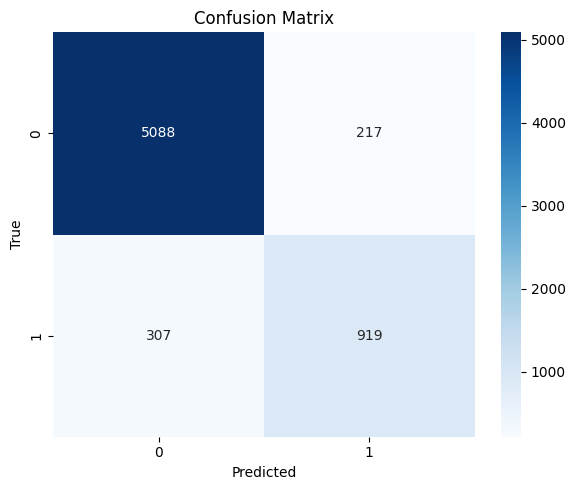

✅ Predictions on test_df saved to: /home/shubham24165/NLP-Project/task_2/predictionsAbuseXLMR_test_english.csv


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModelForSequenceClassification, Trainer
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import torch

# Step 1: Load trained model from checkpoint
model_checkpoint_path = "/home/shubham24165/NLP-Project/task_2/AbuseXLMR_gendered_abuse_english/checkpoint-1635"
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint_path)

# Step 2: Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Step 3: Setup Trainer (reinitialize with new model)
trainer = Trainer(model=model)

# Step 4: Run predictions on test set
predictions_output = trainer.predict(tokenized_test_dataset)

# Step 5: Extract logits, predicted labels, and true labels
logits = predictions_output.predictions
preds = np.argmax(logits, axis=1)

# Force ground truth labels to be integers. Replace None with default value 0.
labels = np.array([int(x) if x is not None else 0 for x in tokenized_test_dataset['final_label']])

print("Unique labels in test dataset:", np.unique(labels))

# Step 6: Compute macro-averaged metrics
precision = precision_score(labels, preds, average='macro')
recall = recall_score(labels, preds, average='macro')
f1 = f1_score(labels, preds, average='macro')

print(f"\n📊 Evaluation on Test Set:")
print(f" Precision (macro): {precision:.4f}")
print(f" Recall    (macro): {recall:.4f}")
print(f" F1 Score  (macro): {f1:.4f}")

# Step 7: Plot confusion matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# Step 8: Collect original input texts from test_df (ensure test_df is properly defined)
input_texts = test_df["text"].tolist()

# Step 9: Save predictions to CSV
df = pd.DataFrame({
    "text": input_texts,
    "true_label": labels,
    "predicted_label": preds
})
csv_path = "/home/shubham24165/NLP-Project/task_2/predictionsAbuseXLMR_test_english.csv"
df.to_csv(csv_path, index=False)
print(f"✅ Predictions on test_df saved to: {csv_path}")